In [122]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

device = 'cuda'

In [123]:
df = pd.read_csv("./data/emotions.csv")
df.head(), df.shape

(   # mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_d_0_a  mean_d_1_a  \
 0        4.62      30.3    -356.0      15.6      26.3       1.070       0.411   
 1       28.80      33.1      32.0      25.8      22.8       6.550       1.680   
 2        8.90      29.4    -416.0      16.7      23.7      79.900       3.360   
 3       14.90      31.6    -143.0      19.8      24.3      -0.584      -0.284   
 4       28.30      31.3      45.2      27.3      24.5      34.800      -5.790   
 
    mean_d_2_a  mean_d_3_a  mean_d_4_a  ...  fft_741_b  fft_742_b  fft_743_b  \
 0      -15.70        2.06        3.15  ...       23.5       20.3       20.3   
 1        2.88        3.83       -4.82  ...      -23.3      -21.8      -21.8   
 2       90.20       89.90        2.03  ...      462.0     -233.0     -233.0   
 3        8.82        2.30       -1.97  ...      299.0     -243.0     -243.0   
 4        3.06       41.40        5.52  ...       12.0       38.1       38.1   
 
    fft_744_b  fft_745_b

In [124]:
classes = {"NEGATIVE": 0, "NEUTRAL": 1, "POSITIVE": 2}
def label_to_num(df):
    temp_df = df.copy()
    temp_df['label_num'] = temp_df['label'].map(classes)
    temp_df = temp_df.drop('label', axis=1)
    return temp_df
df2 = label_to_num(df)

(tensor([[[0.1611, 0.8868, 0.5961,  ..., 0.2121, 0.2121, 0.5208]],
 
         [[0.1852, 0.8375, 0.6085,  ..., 0.2274, 0.2274, 0.5313]],
 
         [[0.2031, 0.9245, 0.4298,  ..., 0.2219, 0.2219, 0.6228]],
 
         ...,
 
         [[0.2431, 0.9232, 0.3850,  ..., 0.1794, 0.1794, 0.6544]],
 
         [[0.2584, 0.9392, 0.6125,  ..., 0.2674, 0.2674, 0.5308]],
 
         [[0.1079, 0.6052, 0.5941,  ..., 0.2485, 0.2485, 0.5329]]],
        device='cuda:0'),
 torch.Size([427, 1, 2548]),
 torch.Size([1705]),
 torch.Size([427]))

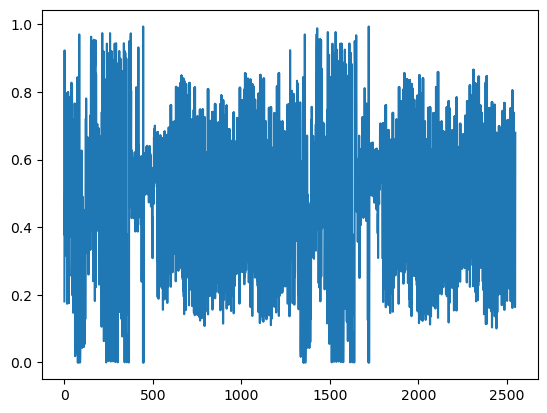

In [125]:
# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df_raw = pd.read_csv("./data/emotions.csv")
df = label_to_num(df_raw)

X = df.drop('label_num', axis=1)
y = df['label_num']

scaler = MinMaxScaler((0,1))
X = scaler.fit_transform(X)
plt.plot(X[0])

X, y = torch.tensor(X).to(device), torch.tensor(y.values).to(device)
X, y = X.float().unsqueeze(dim=1), y.long()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state = 42)
X_train[0:10], X_test.shape, y_train.shape, y_test.shape

In [126]:
from torch import nn

class ConvNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, padding = 1),
            nn.LeakyReLU(),
            nn.Conv1d(8, 8, kernel_size=3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2)
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8 * 1274 * 1, 3)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.linear(x)
        return x
model_0 = ConvNN().to(device)
model_0.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[-0.1480,  0.4861,  0.1641]],
              
                      [[ 0.4788,  0.4629, -0.4073]],
              
                      [[-0.4407,  0.2319, -0.3945]],
              
                      [[-0.0830,  0.5463, -0.3936]],
              
                      [[ 0.4822, -0.5420,  0.5769]],
              
                      [[ 0.3305, -0.0276,  0.0073]],
              
                      [[ 0.2679,  0.2599,  0.1028]],
              
                      [[-0.0227,  0.2188,  0.5516]]], device='cuda:0')),
             ('conv_block_1.0.bias',
              tensor([-0.0606, -0.1628, -0.2353,  0.1949,  0.4338,  0.0396,  0.4215,  0.1506],
                     device='cuda:0')),
             ('conv_block_1.2.weight',
              tensor([[[ 0.0934, -0.1238, -0.0077],
                       [-0.0763, -0.1073, -0.1974],
                       [-0.1783,  0.1490,  0.0795],
                       [-0.0234, -0.1852, -0.

In [127]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model_0.parameters(), lr = 0.05)
acc_fn = Accuracy(task='multiclass', num_classes=3).to(device)

In [128]:
def train_step(model: nn.Module,
              X: torch.Tensor,
              y: torch.Tensor,
              loss_fn: torch.nn,
              acc_fn: Accuracy,
              optimizer: torch.optim,
              device: str):
    model.train()

    X, y = X.to(device), y.to(device)

    logits = model(X)
    preds = logits.softmax(dim=1).argmax(dim=1)

    loss = loss_fn(logits, y)
    acc = acc_fn(y, preds)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss, acc

In [129]:
def test_step(model: nn.Module,
              X: torch.Tensor,
              y: torch.Tensor,
              loss_fn: torch.nn,
              acc_fn: Accuracy,
              device: str):
    model.eval()

    X, y = X.to(device), y.to(device)

    with torch.inference_mode():
        logits = model(X)
        preds = logits.softmax(dim=1).argmax(dim=1).long()
        loss = loss_fn(logits, y)
        acc = acc_fn(y, preds)
    
    return loss, acc

test_step(model_0, X_test, y_test, loss_fn, acc_fn, device)

(tensor(1.0963, device='cuda:0'), tensor(0.4052, device='cuda:0'))

In [130]:
epochs = 500

train_loss_record = []
train_acc_record = []
test_loss_record = []
test_acc_record = []

for epoch in range(epochs):
    train_loss, train_acc = train_step(model_0, X_train, y_train, loss_fn, acc_fn, optimizer, device)
    test_loss, test_acc = test_step(model_0, X_test, y_test, loss_fn, acc_fn, device)

    train_loss_record.append(train_loss.item())
    train_acc_record.append(train_acc.item())

    test_loss_record.append(test_loss.item())
    test_acc_record.append(test_acc.item())

    print(f"Epoch: {epoch} | Train loss {train_loss} | Train acc: {train_acc} | Test loss: {test_loss} | Test acc: {test_acc}")

Epoch: 0 | Train loss 1.0960731506347656 | Train acc: 0.38592374324798584 | Test loss: 1.0845224857330322 | Test acc: 0.3348946273326874
Epoch: 1 | Train loss 1.0834964513778687 | Train acc: 0.331378310918808 | Test loss: 1.1072373390197754 | Test acc: 0.34660422801971436
Epoch: 2 | Train loss 1.1079593896865845 | Train acc: 0.3331378400325775 | Test loss: 1.248367190361023 | Test acc: 0.3348946273326874
Epoch: 3 | Train loss 1.243607521057129 | Train acc: 0.331378310918808 | Test loss: 1.100525140762329 | Test acc: 0.3911007046699524
Epoch: 4 | Train loss 1.1001139879226685 | Train acc: 0.37008798122406006 | Test loss: 1.0454596281051636 | Test acc: 0.6932084560394287
Epoch: 5 | Train loss 1.0455964803695679 | Train acc: 0.6903225779533386 | Test loss: 1.0239040851593018 | Test acc: 0.8735362887382507
Epoch: 6 | Train loss 1.023604154586792 | Train acc: 0.8533724546432495 | Test loss: 1.0062655210494995 | Test acc: 0.8266978859901428
Epoch: 7 | Train loss 1.0054823160171509 | Train ac

Text(0.5, 0, 'Epochs')

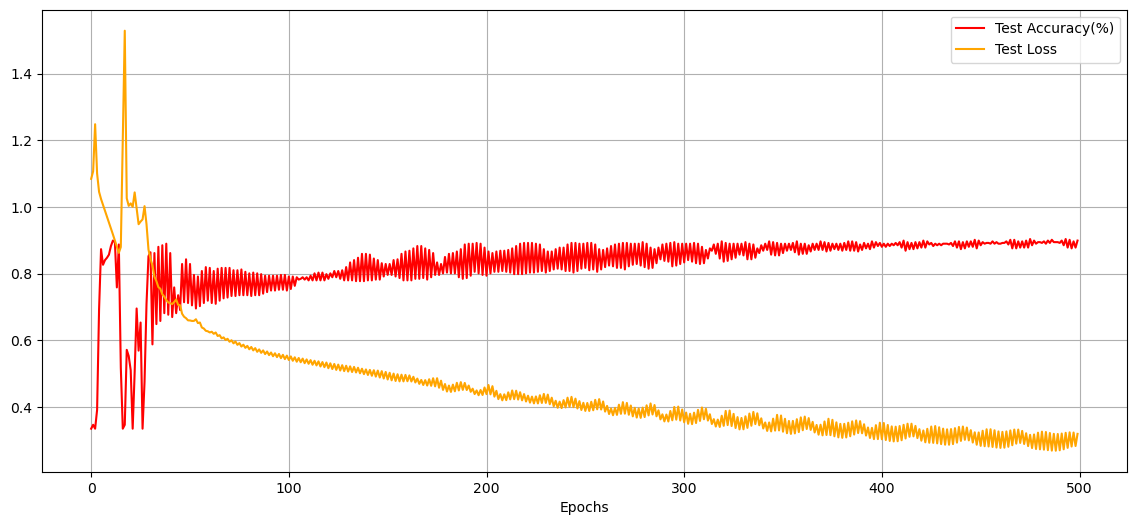

In [131]:
plt.figure(figsize=(14,6))
plt.plot(test_acc_record, label = "Test Accuracy(%)", c='red')
plt.plot(test_loss_record, label = "Test Loss", c='orange')
plt.grid()
plt.legend()
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

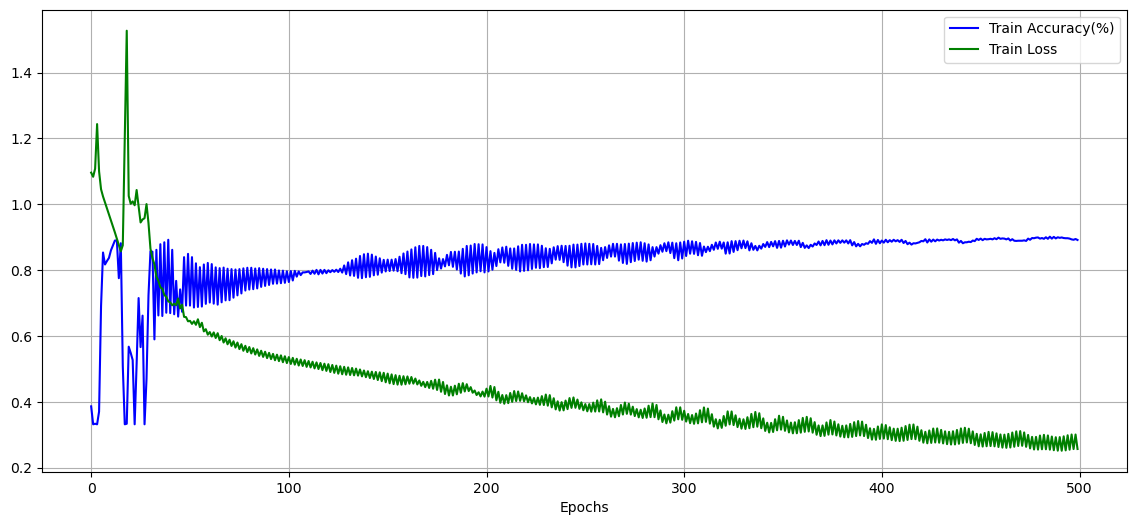

In [132]:
plt.figure(figsize=(14,6))
plt.plot(train_acc_record, label = "Train Accuracy(%)", c='blue')
plt.plot(train_loss_record, label = "Train Loss", c='green')
plt.grid()
plt.legend()
plt.xlabel("Epochs")

In [133]:
# save to .pth file
torch.save(model_0.state_dict(), "./models/brainwave_emotion_cnn.pth")